In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| default_exp utils

# Understanding Dataset


Predictive Maintenance (PdM) is a great application of Survival Analysis since it consists in predicting when equipment failure will occur and therefore alerting the maintenance team to prevent that failure.

### ` Objectives`
> - To estimate Remaining Useful Time(RUL) of a machine/component
> - To Predict Probability of Failure in Next N days
> - Create a Dashboard for tracking and alerts

# Setup
> Requirements

### `Requirements`
> To automatically generate requirements.txt file type `pipreqs .` in terminal . If requirements.txt already exists, use `pipreqs --force .` to overwrite it

- matplotlib==3.7.1
- numpy==1.24.2
- pandas==2.0.1
- scikit_learn==1.2.2
- scikit_survival==0.20.0
- setuptools==65.6.3

# Dataset 

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shap
from boruta import BorutaPy

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from PredictiveMaintenance2 import Datasets,Visualize,FeatureEng,Model

### load dataset

In [ ]:
file = r'C:\Users\Lalitha\Desktop\GyanData\predictive-maintenance\PredictiveMaintenance2\nbs\predictive_maintenance_dataset.csv'
machine_data = Datasets.load_dataset(file,'r')

machine_data.head(2)

File exists
.csv file extension is supported


,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,01-01-2015,S1F01085,0,215630672,55,0,52,6,407438,0,0,7
1,01-01-2015,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0


### Explore dataset
- dataset.shape
- dataset.null values
- dataset.duplicate rows

In [ ]:
Datasets.explore_dataset(dataset_df = machine_data,
                         NAN_action='drop',
                         duplicate_action = 'drop',
                         duplicate_subset=['device', 'date'])

In Dataset 
Observations : 124494 
Columns :12

-----NAN values-----
date       0
device     0
failure    0
metric1    0
metric2    0
metric3    0
metric4    0
metric5    0
metric6    0
metric7    0
metric8    0
metric9    0
dtype: int64

-----Duplicate records-----
1

drop Duplicates successful 



In [ ]:
#feature function  - explain every feature
FeatureEng.explain_features(dataset_df = machine_data,
                            machine_Unique_Identifer = 'device',
                            observation_date = 'date',
                            failure = 'failure',
                            sensor_values = ['metric1','metric2'])

There are 1169 unique machines

Observations are recorded for 304 days

 First 5 unique dates are 
Index(['01-01-2015', '01-02-2015', '01-03-2015', '01-04-2015', '01-05-2015'], dtype='object', name='date')

Number of records where, 
Failure = FALSE are 124387 
Failure = TRUE are 106

Percentage of failures : 0.085%

--Warning---: 
Number of record of event type failure are too low 
Dataset is unbalanced.
Use expand_target_window function


In [ ]:
# remove invalid records of machines that are dropped out during experiment
machine_data = FeatureEng.remove_invalid_records(dataset_df=machine_data,machine_Unique_Identifer='device',observation_date='date',failure='failure')
machine_data.head(2)

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,2015-01-01,S1F023H2,0,141503600,0,0,1,19,494462,16,16,3
1,2015-01-02,S1F023H2,0,161679800,0,0,1,19,495730,16,16,3


In [ ]:
machine_data.shape

(19805, 12)

# Feature creation

### Add RUL

In [ ]:
"""if RUL or survival time or age of equipment is not given calculate it from date and failure columns"""
machine_data_rul = FeatureEng.calculate_rul(dataset_df=machine_data,observation_date='date',machine_Unique_Identifer='device')
machine_data_rul.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,RUL
0,2015-01-01,S1F023H2,0,141503600,0,0,1,19,494462,16,16,3,18
1,2015-01-01,W1F1BZTM,0,139929672,0,0,0,13,42,0,0,5,119
2,2015-01-01,W1F1BS0H,0,78866488,0,0,0,14,267374,0,0,0,189
3,2015-01-01,S1F0EGMT,0,84554144,0,0,0,9,196324,0,0,0,305
4,2015-01-01,W1F1BFP5,0,141049448,16,0,12,8,139874,0,0,0,200


### Add Survival Time

In [ ]:
# add survival time
"""if RUL or survival time or age of equipment is not given calculate it from date and failure columns"""
machine_data_rul = FeatureEng.calculate_survival_time(dataset_df=machine_data_rul,observation_date='date',machine_Unique_Identifer='device')
machine_data_rul.head(2)

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,RUL,SurvivalTime
0,2015-01-01,S1F023H2,0,141503600,0,0,1,19,494462,16,16,3,18,1
1,2015-01-01,W1F0FW0S,0,196878448,0,0,17,64,185793,0,0,2,27,1


In [ ]:
# sort the file by dates and then by devices 
machine_data_rul = machine_data_rul.sort_values(['date','device'],ascending = [True,True]).reset_index(drop=True)
machine_data_rul.head(2)

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,RUL,SurvivalTime
0,2015-01-01,S1F023H2,0,141503600,0,0,1,19,494462,16,16,3,18,1
1,2015-01-01,S1F03YZM,0,55587136,0,0,0,7,199132,0,0,0,214,1


## Encoding features- categorical to numerical

In [ ]:
# encoding categorical variables to numerical
machine_data_rul = FeatureEng.to_numerical(dataset_df = machine_data_rul)
machine_data_rul.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,RUL,SurvivalTime
0,2015-01-01,0,0,141503600,0,0,1,19,494462,16,16,3,18,1
1,2015-01-01,1,0,55587136,0,0,0,7,199132,0,0,0,214,1
2,2015-01-01,2,0,12568128,136,0,2,6,380112,0,0,2,198,1
3,2015-01-01,3,0,50147888,528,0,4,9,381198,32,32,3,6,1
4,2015-01-01,4,0,8471680,0,0,0,11,436682,0,0,0,44,1


In [ ]:
# apply smote ---

In [ ]:
# save the data to a .csv file
machine_data_rul.to_csv('Machine_Data_Preprocessed.csv',index = False)

# Visualization

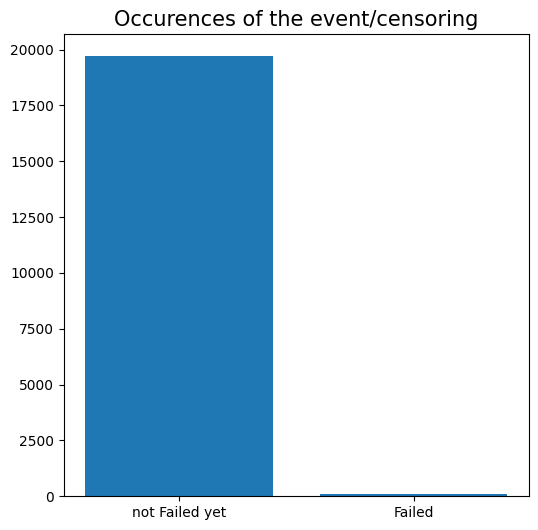

In [ ]:
# failure column
Visualize.plot(feature_type='event',feature='failure',dataset=machine_data_rul)

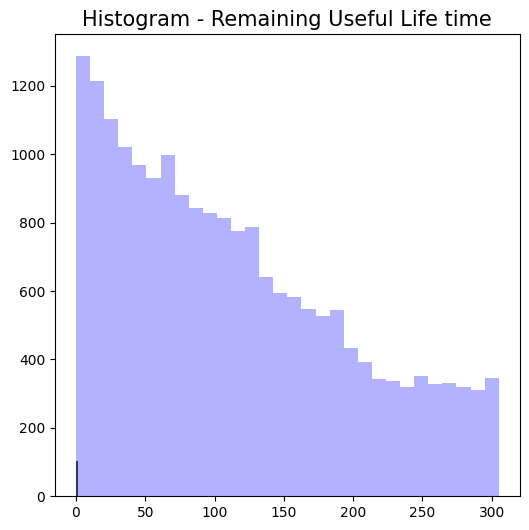

In [ ]:
# rul column
Visualize.plot(feature_type='time',feature='RUL',dataset=machine_data_rul)


   device  RUL
0       0   18
1       1  214
2       2  198
3       3    6
4       4   44


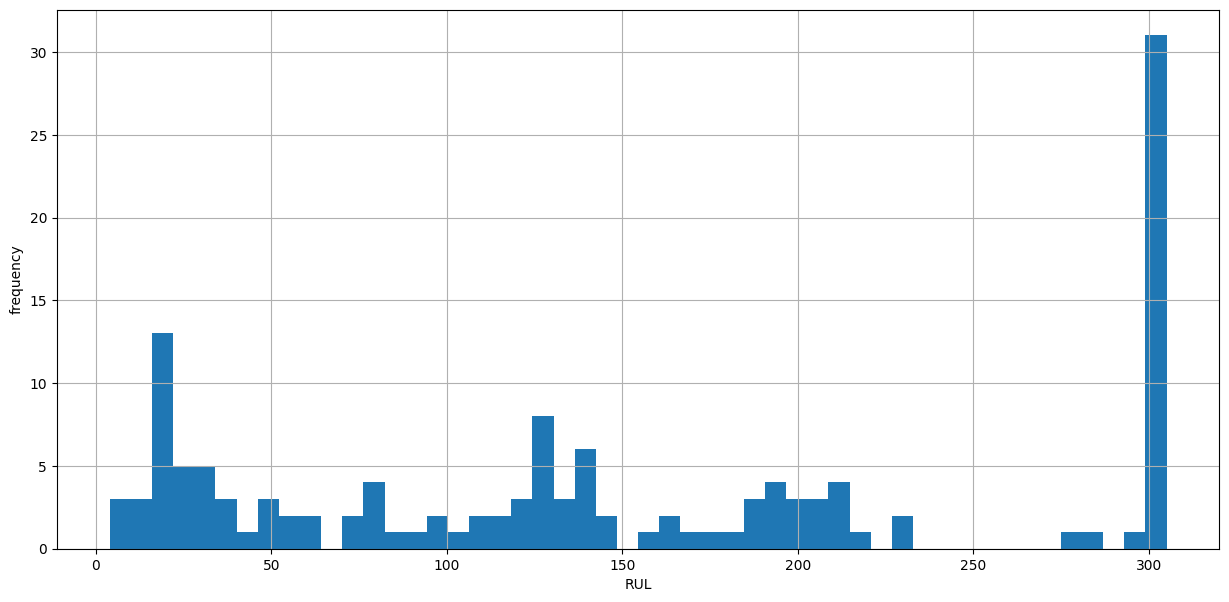

In [ ]:
# plot histogram for rul
df_max_rul = machine_data_rul[['device', 'RUL']].groupby('device').max().reset_index()
print(df_max_rul.head())
df_max_rul['RUL'].hist(bins=50, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

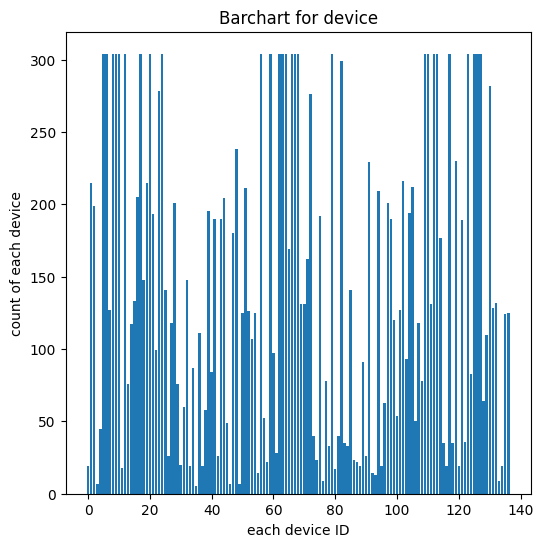

In [ ]:
# visualize
cats = ['device']
nums = ['metric1','metric2','metric3','metric4','metric5','metric6','metric7','metric8','metric9']

for feature in cats:
    Visualize.plot(feature=feature,feature_type='Categorical',dataset=machine_data_rul)


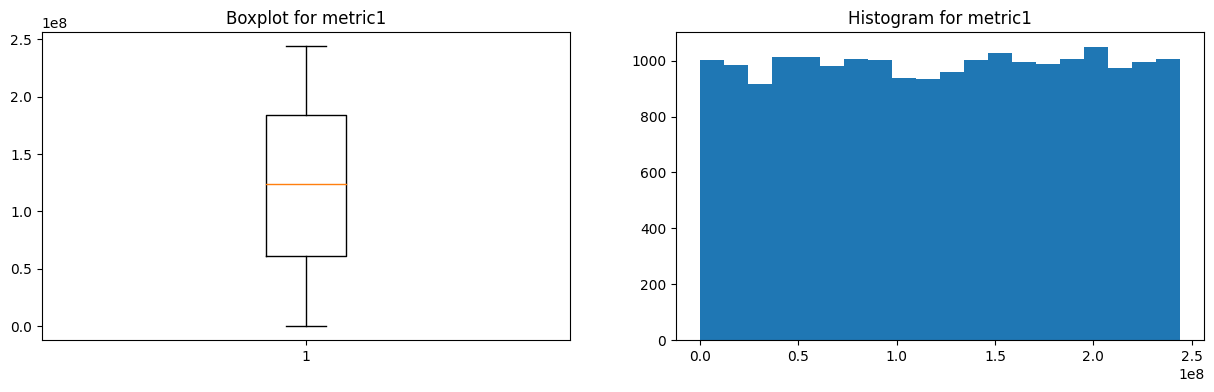

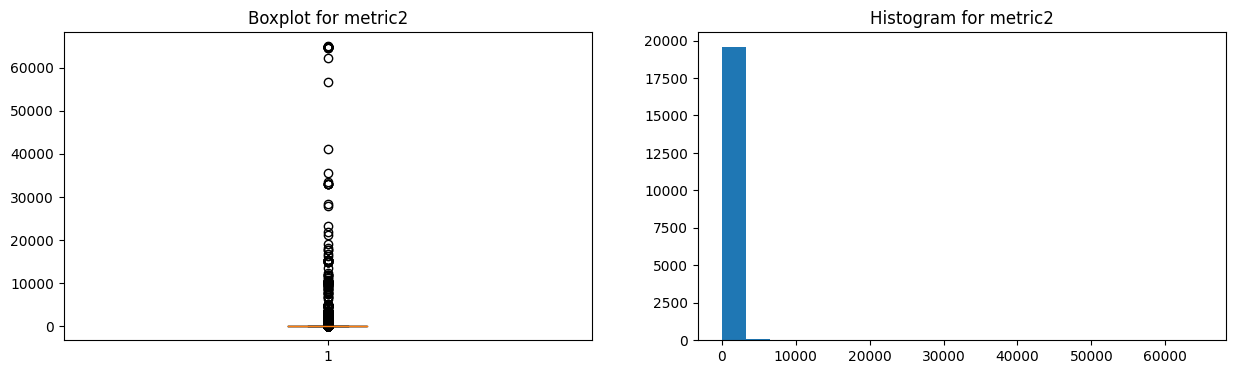

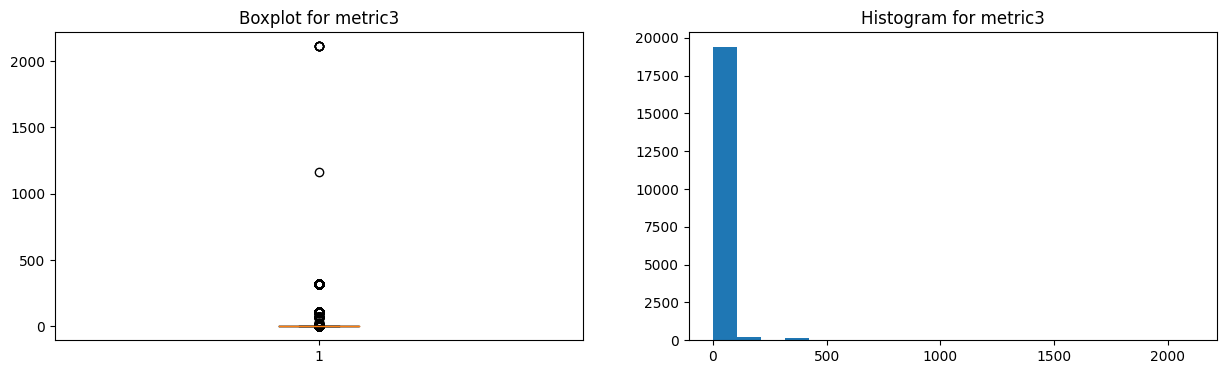

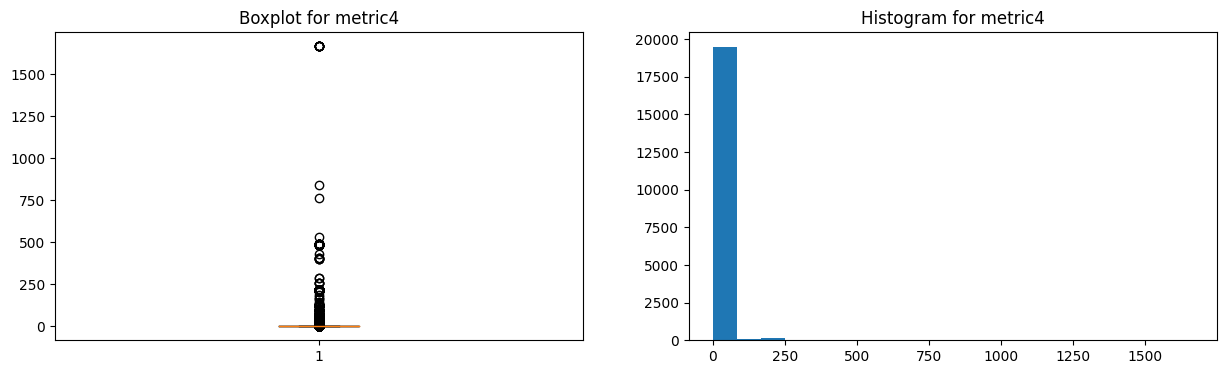

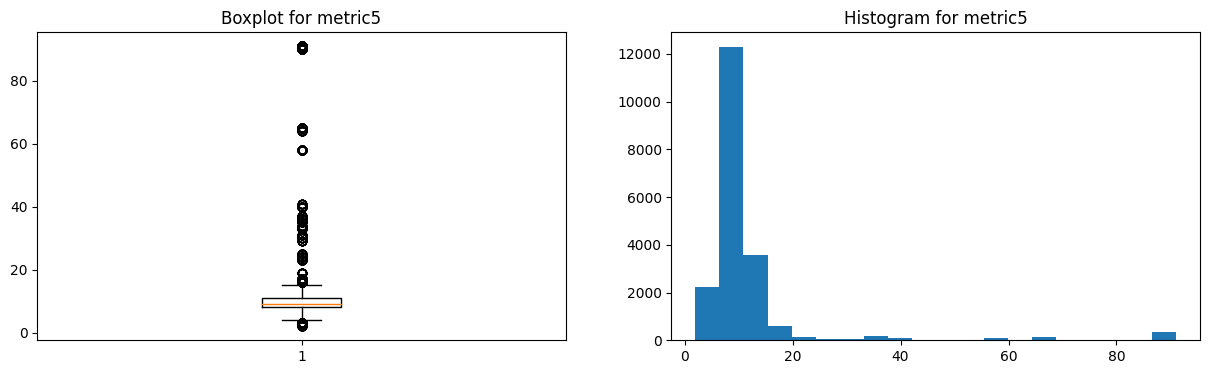

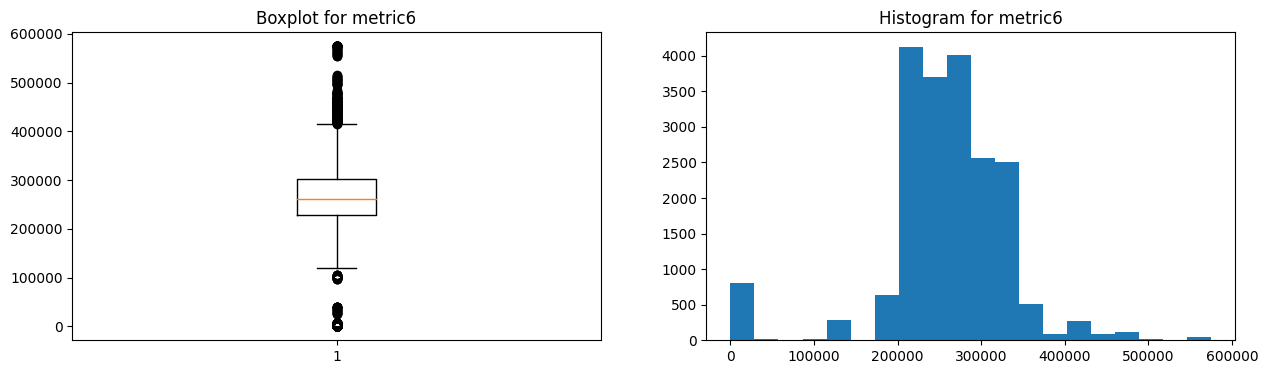

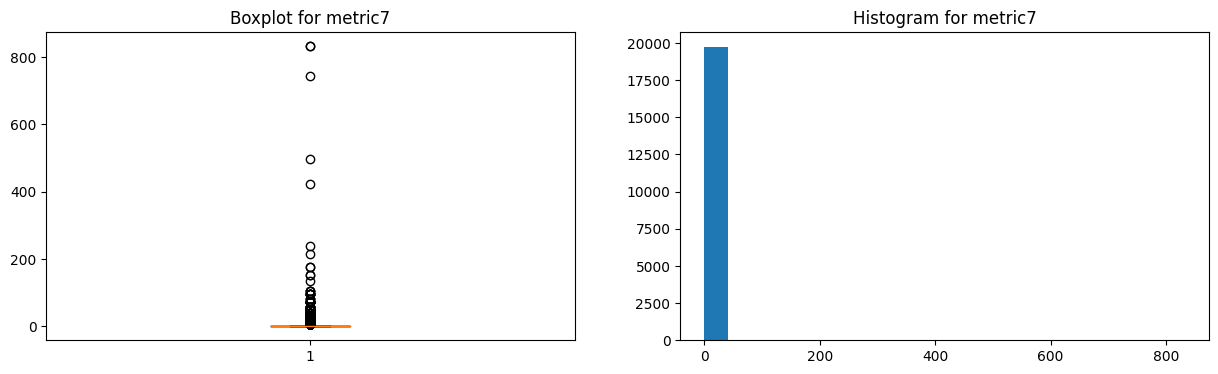

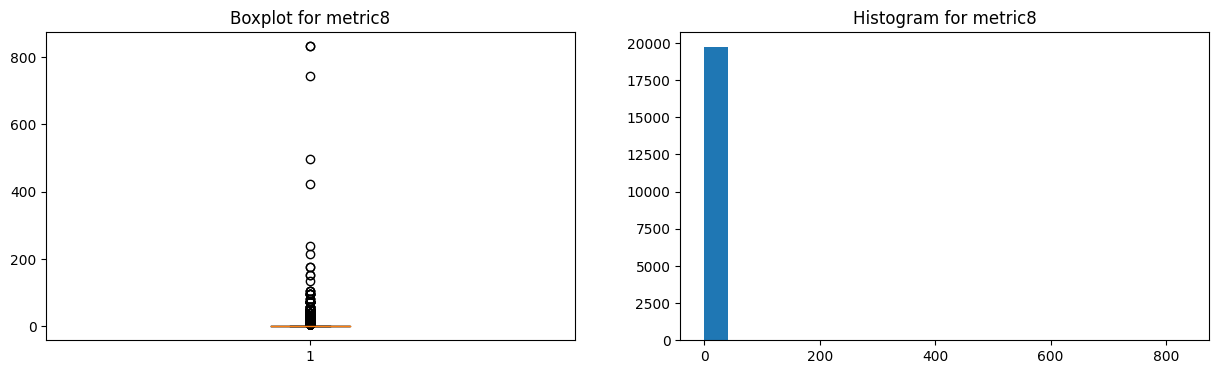

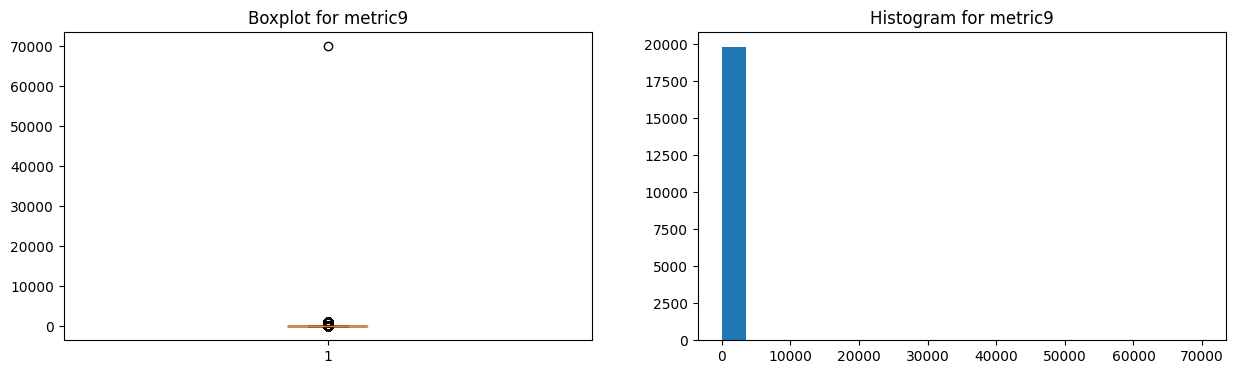

In [ ]:
for feature in nums:
    Visualize.plot(feature=feature,feature_type='Numerical',dataset=machine_data_rul)


In [ ]:
def plot_sensor(sensor_name):
    plt.figure(figsize=(13,5))
    for i in machine_data_rul['device'].unique():
        if (i % 10 == 0):  # only plot every 10th device
            plt.plot('RUL', sensor_name, 
                     data=machine_data_rul[machine_data_rul['device']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

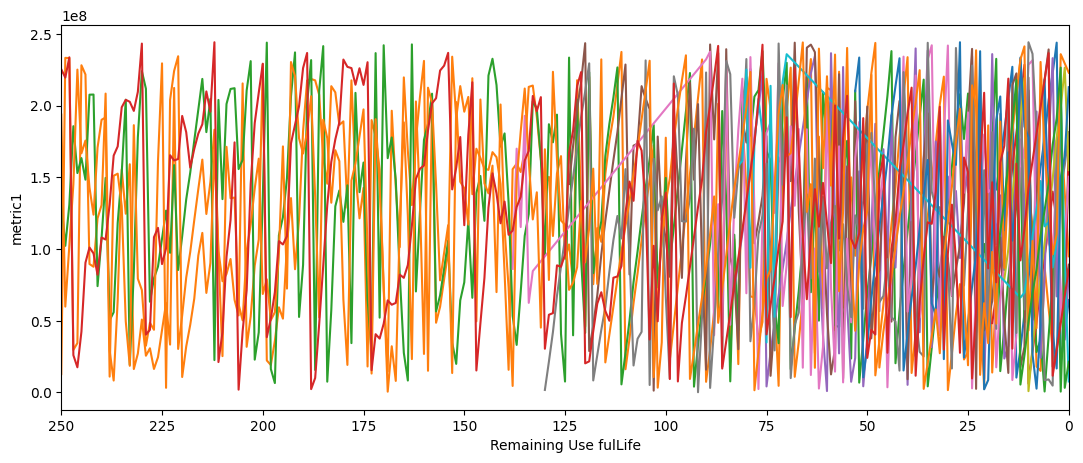

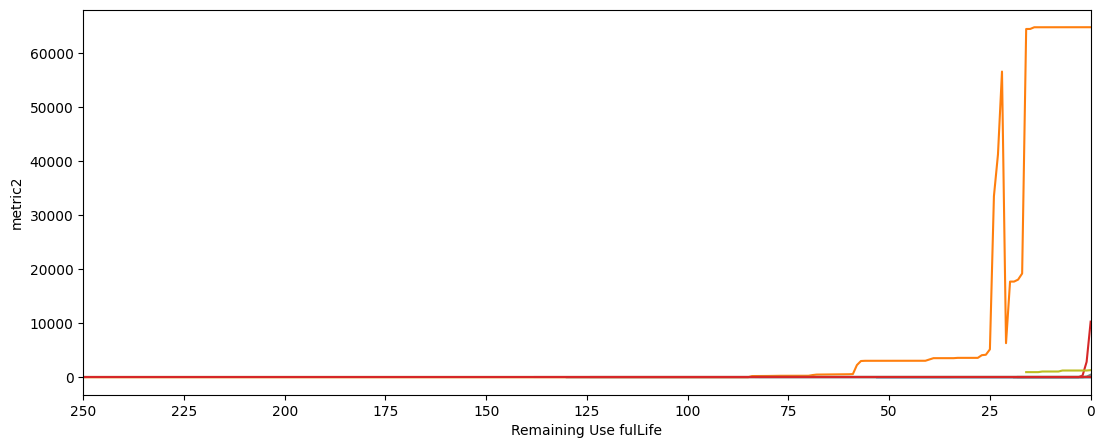

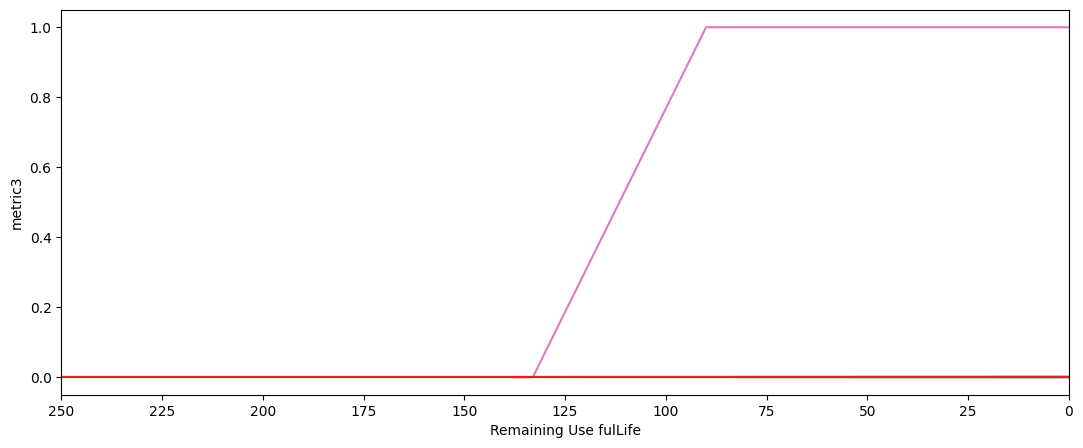

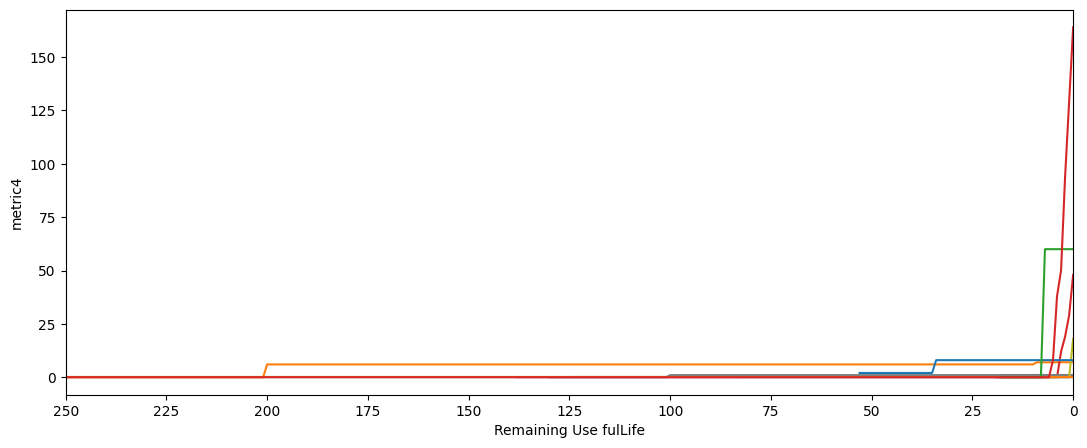

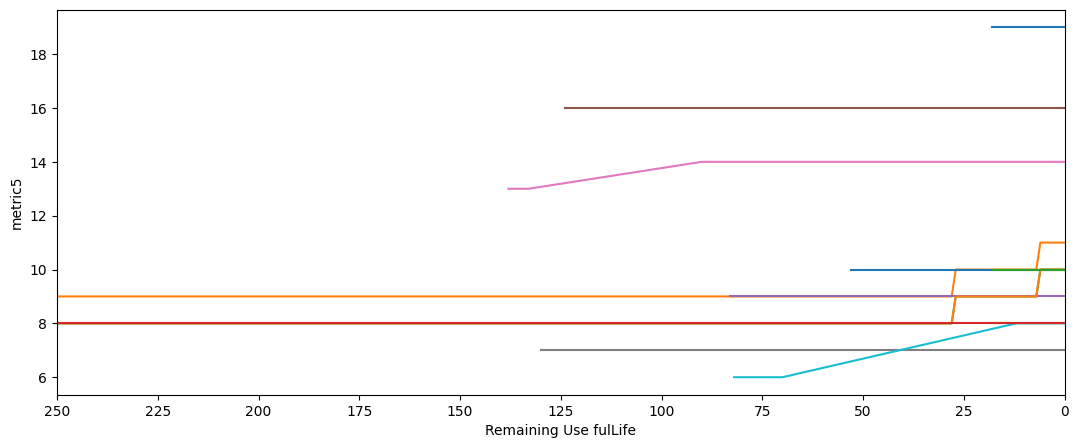

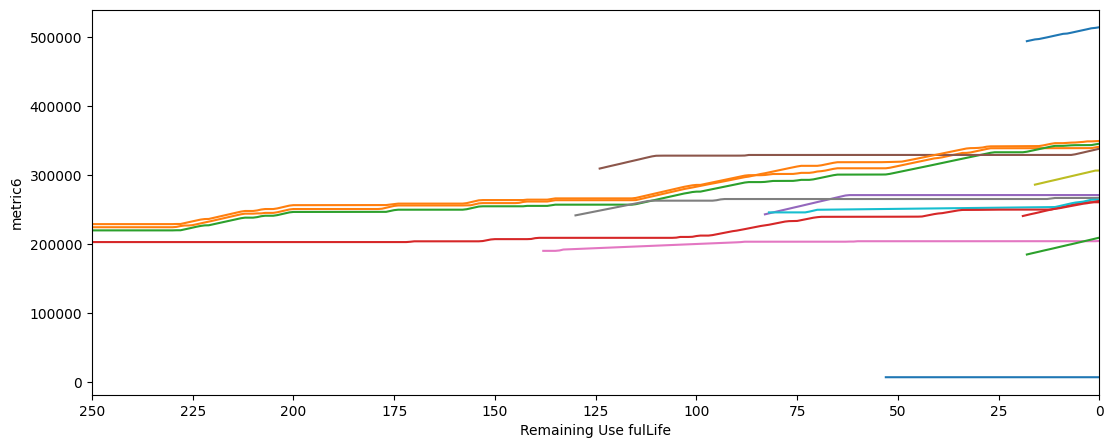

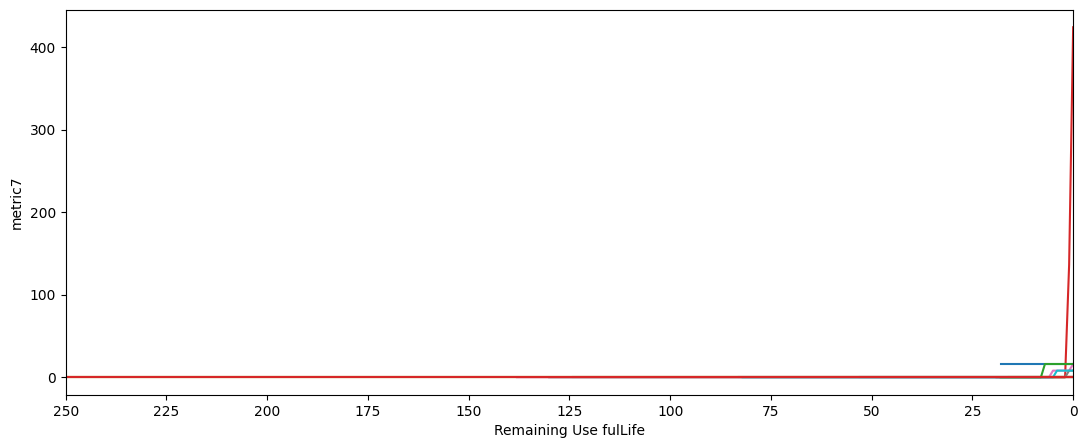

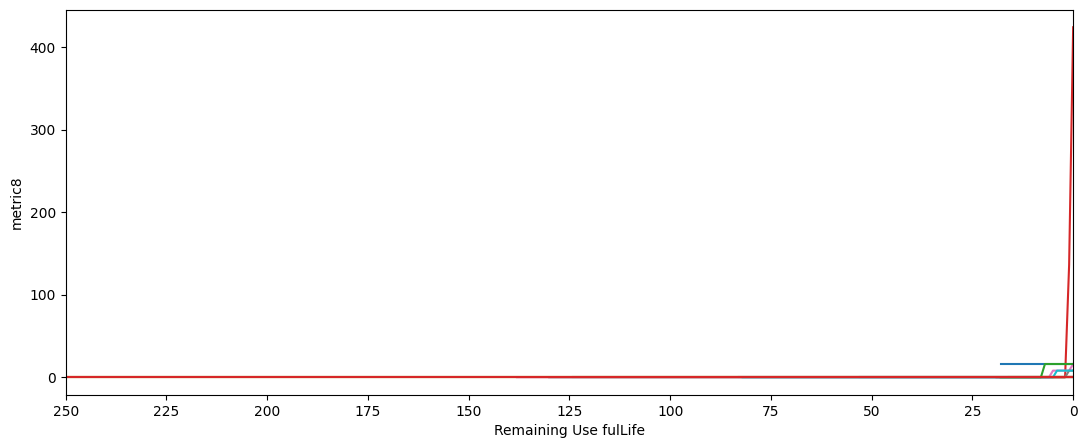

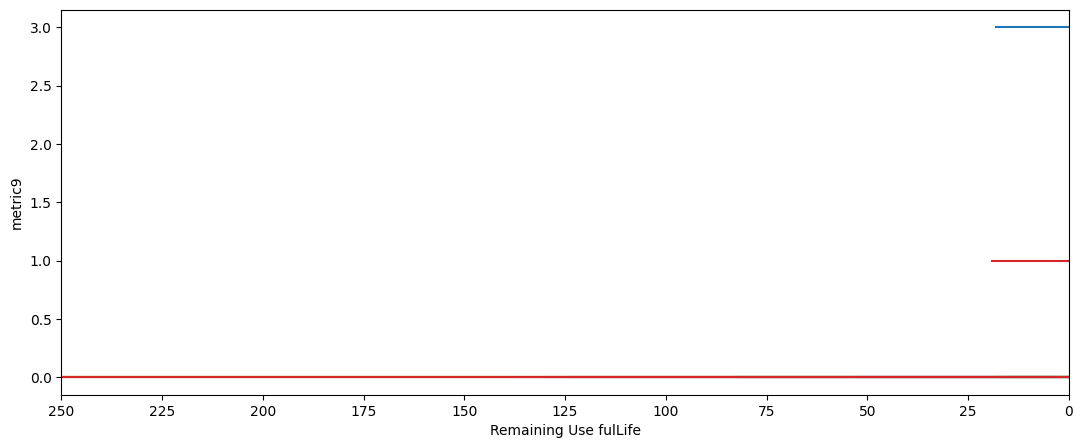

In [ ]:
metric_names = ['metric1','metric2','metric3','metric4','metric5','metric6','metric7','metric8','metric9',]
for sensor_name in metric_names:
    plot_sensor(sensor_name)

In [ ]:
# there are too many outliers and data is not normally distributed
# metric 9 seems to be a waste as it is constant

<Axes: >

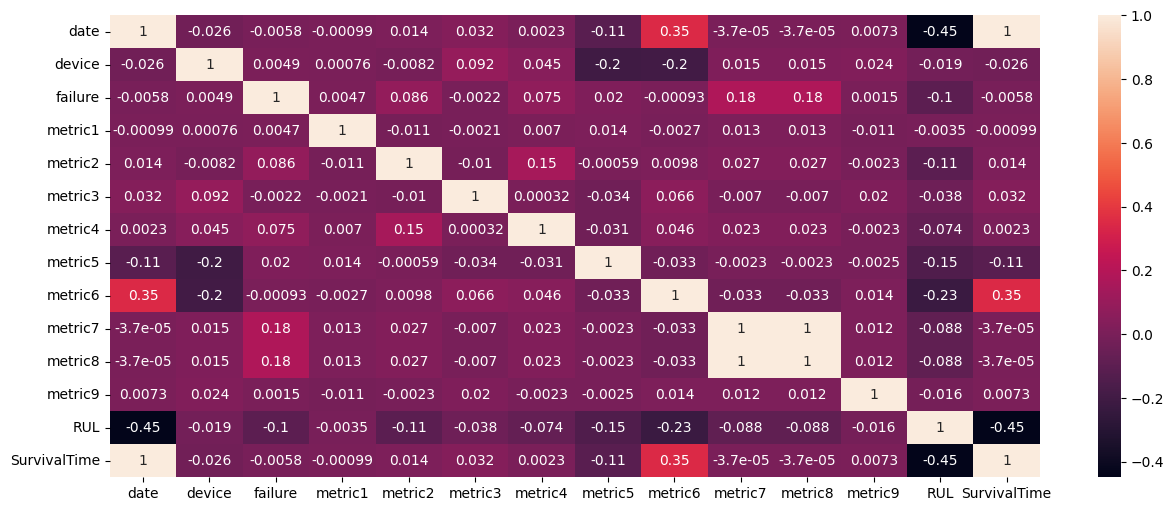

In [ ]:
cor = machine_data_rul.corr()

plt.figure(figsize=(15,6))
sns.heatmap(cor,annot = True)

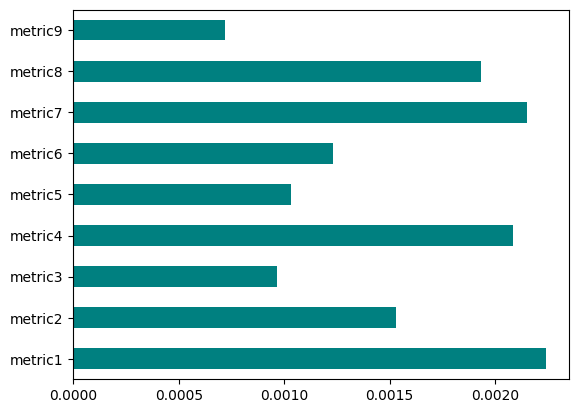

In [ ]:
# no correlation too
# check with classification reports

metric_names = ['metric1','metric2','metric3','metric4','metric5','metric6','metric7','metric8','metric9',]
x =  machine_data_rul[metric_names]
y = machine_data_rul['failure']
imp = mutual_info_classif(x,y)
feat_imp = pd.Series(imp,metric_names)
feat_imp.plot(kind='barh', color = 'teal')
plt.show()

In [ ]:
# remove metric 9 

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()